In [30]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
import time
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           f1_score, roc_curve, auc, precision_recall_curve)
from sklearn.preprocessing import label_binarize
from itertools import cycle
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [31]:
# Load Dataset
data_path = '/home/biplovgautam/Desktop/aiassignment/data/financial_sentiment_preprocessed.csv'
df = pd.read_csv(data_path)

print(f"Dataset loaded: {df.shape}")
print(f"Class distribution:\n{df['sentiment'].value_counts()}")
print(f"Missing values: {df.isnull().sum().sum()}")

Dataset loaded: (3260, 2)
Class distribution:
sentiment
positive    1200
neutral     1200
negative     860
Name: count, dtype: int64
Missing values: 0


## Financial Sentiment Analysis - Model Training

### Phase 1: Baseline Model Training
Train initial Naive Bayes model on imbalanced dataset to establish baseline performance.

In [32]:
# Split Data for traing and testing
X = df['text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training: {len(X_train)} | Testing: {len(X_test)}")
print(f"Train distribution: {dict(y_train.value_counts())}")
print(f"Test distribution: {dict(y_test.value_counts())}")

Training: 2608 | Testing: 652
Train distribution: {'neutral': np.int64(960), 'positive': np.int64(960), 'negative': np.int64(688)}
Test distribution: {'neutral': np.int64(240), 'positive': np.int64(240), 'negative': np.int64(172)}


In [33]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2),
    stop_words='english',
    lowercase=True,
    strip_accents='ascii'
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training matrix: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Top features by class
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nTop 5 tokens per class:")
for sentiment in ['negative', 'neutral', 'positive']:
    sentiment_texts = X_train[y_train == sentiment]
    sentiment_tfidf = tfidf_vectorizer.transform(sentiment_texts)
    sentiment_scores = sentiment_tfidf.sum(axis=0).A1
    top_indices = np.argsort(sentiment_scores)[-5:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    print(f"{sentiment.capitalize()}: {', '.join(top_features)}")

Training matrix: (2608, 7132)
Vocabulary size: 7132

Top 5 tokens per class:
Negative: num, eur, eur num, mn, num mn
Neutral: num, num num, company, said, finnish
Positive: num, eur, eur num, year, num num


In [34]:
# Train Baseline Model
naive_bayes_model = MultinomialNB(alpha=1.0, fit_prior=True)
naive_bayes_model.fit(X_train_tfidf, y_train)

print(f"Model trained with {naive_bayes_model.n_features_in_:,} features")
print(f"Classes: {naive_bayes_model.classes_}")

Model trained with 7,132 features
Classes: ['negative' 'neutral' 'positive']


In [35]:
# Evaluate Baseline Model
y_pred = naive_bayes_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"BASELINE MODEL PERFORMANCE")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"Macro F1: {macro_f1:.4f}")

class_report = classification_report(y_test, y_pred, output_dict=True)
for class_name in ['negative', 'neutral', 'positive']:
    f1 = class_report[class_name]['f1-score']
    print(f"{class_name.capitalize()} F1: {f1:.3f}")

cm = confusion_matrix(y_test, y_pred, labels=naive_bayes_model.classes_)

BASELINE MODEL PERFORMANCE
Accuracy: 0.6626 (66.3%)
Macro F1: 0.6374
Negative F1: 0.516
Neutral F1: 0.713
Positive F1: 0.684


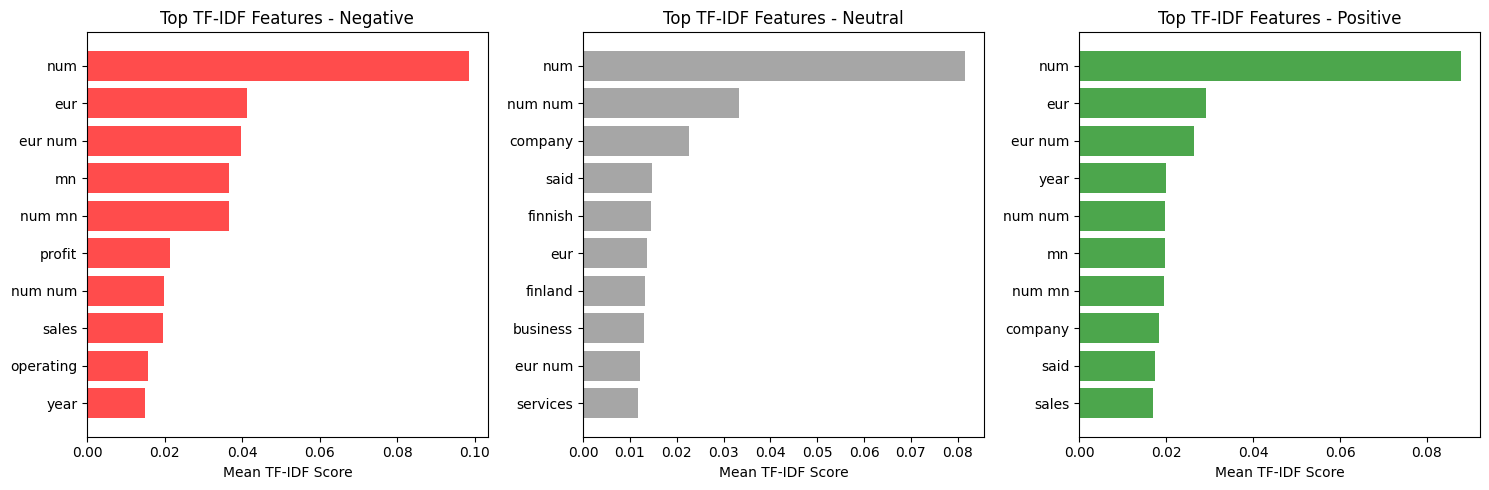

In [36]:
# TF-IDF Feature Analysis Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Get top TF-IDF features for each class
for idx, sentiment in enumerate(['negative', 'neutral', 'positive']):
    # Get texts for this class
    sentiment_mask = y_train == sentiment
    sentiment_texts = X_train[sentiment_mask]
    
    # Transform and get mean TF-IDF scores
    sentiment_tfidf = tfidf_vectorizer.transform(sentiment_texts)
    mean_scores = sentiment_tfidf.mean(axis=0).A1
    
    # Get top 10 features
    top_indices = np.argsort(mean_scores)[-10:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_scores = [mean_scores[i] for i in top_indices]
    
    # Plot
    axes[idx].barh(range(len(top_features)), top_scores, 
                   color=['red', 'gray', 'green'][idx], alpha=0.7)
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features)
    axes[idx].set_title(f'Top TF-IDF Features - {sentiment.capitalize()}')
    axes[idx].set_xlabel('Mean TF-IDF Score')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

## Phase 2: Data Balancing & Final Model Training

Balance dataset to 1,200 samples per class by duplicating longest negative sentences to improve minority class detection.

In [37]:
# Balance Dataset
df_full = pd.read_csv('/home/biplovgautam/Desktop/aiassignment/data/financial_sentiment_preprocessed.csv')

negative_samples = df_full[df_full['sentiment'] == 'negative'].copy()
positive_samples = df_full[df_full['sentiment'] == 'positive'].copy()
neutral_samples = df_full[df_full['sentiment'] == 'neutral'].copy()

# Duplicate longest negative samples to reach 1200
negative_samples['text_length'] = negative_samples['text'].str.len()
negative_sorted = negative_samples.sort_values('text_length', ascending=False)

needed_samples = 1200 - len(negative_samples)
longest_negatives = negative_sorted.head(needed_samples)
balanced_negative = pd.concat([negative_samples, longest_negatives[['text', 'sentiment']]], ignore_index=True)

# Create balanced dataset
df_balanced = pd.concat([
    balanced_negative,
    positive_samples[['text', 'sentiment']].head(1200),
    neutral_samples[['text', 'sentiment']].head(1200)
], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced dataset: {df_balanced.shape}")
print(f"Distribution: {dict(df_balanced['sentiment'].value_counts())}")

Balanced dataset: (3600, 3)
Distribution: {'positive': np.int64(1200), 'neutral': np.int64(1200), 'negative': np.int64(1200)}


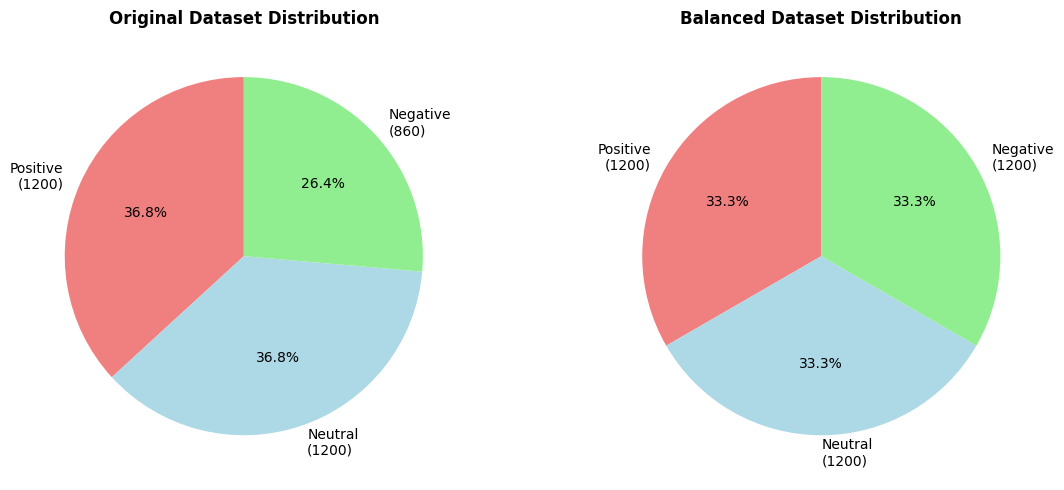

📈 Data balancing achieved: All classes now have equal representation (1,200 samples each)


In [38]:
# Data Balancing Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Before balancing
original_dist = df_full['sentiment'].value_counts()
wedges1, texts1, autotexts1 = ax1.pie(original_dist.values, 
                                      labels=[f'{l.title()}\n({c})' for l, c in original_dist.items()],
                                      autopct='%1.1f%%', 
                                      colors=['lightcoral', 'lightblue', 'lightgreen'],
                                      startangle=90)
ax1.set_title('Original Dataset Distribution', fontweight='bold')

# After balancing
balanced_dist = df_balanced['sentiment'].value_counts()
wedges2, texts2, autotexts2 = ax2.pie(balanced_dist.values,
                                      labels=[f'{l.title()}\n({c})' for l, c in balanced_dist.items()],
                                      autopct='%1.1f%%',
                                      colors=['lightcoral', 'lightblue', 'lightgreen'],
                                      startangle=90)
ax2.set_title('Balanced Dataset Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

print("📈 Data balancing achieved: All classes now have equal representation (1,200 samples each)")

In [39]:
# Train Final Balanced Model
X_balanced = df_balanced['text']
y_balanced = df_balanced['sentiment']

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# Vectorize with same parameters
tfidf_balanced = TfidfVectorizer(
    max_features=10000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2),
    stop_words='english',
    lowercase=True,
    strip_accents='ascii'
)

X_train_bal_tfidf = tfidf_balanced.fit_transform(X_train_bal)
X_test_bal_tfidf = tfidf_balanced.transform(X_test_bal)

# Train final model
nb_balanced = MultinomialNB(alpha=1.0, fit_prior=True)
nb_balanced.fit(X_train_bal_tfidf, y_train_bal)

print(f"Final model trained: {X_train_bal_tfidf.shape}")
print(f"Features: {len(tfidf_balanced.vocabulary_):,}")

Final model trained: (2880, 8289)
Features: 8,289


In [40]:
# Evaluate Final Model
y_pred_bal = nb_balanced.predict(X_test_bal_tfidf)
accuracy_bal = accuracy_score(y_test_bal, y_pred_bal)
macro_f1_bal = f1_score(y_test_bal, y_pred_bal, average='macro')

print("FINAL MODEL PERFORMANCE")
print(f"Accuracy: {accuracy_bal:.4f} ({accuracy_bal*100:.1f}%)")
print(f"Macro F1: {macro_f1_bal:.4f}")

# Compare with baseline
print(f"\nIMPROVEMENT:")
print(f"Accuracy: {accuracy:.3f} → {accuracy_bal:.3f} ({((accuracy_bal-accuracy)/accuracy*100):+.1f}%)")
print(f"Macro F1: {macro_f1:.3f} → {macro_f1_bal:.3f} ({((macro_f1_bal-macro_f1)/macro_f1*100):+.1f}%)")

class_report_bal = classification_report(y_test_bal, y_pred_bal, output_dict=True)
print(f"\nPer-class F1 scores:")
for class_name in ['negative', 'neutral', 'positive']:
    bal_f1 = class_report_bal[class_name]['f1-score']
    print(f"{class_name.capitalize()}: {bal_f1:.3f}")

cm_bal = confusion_matrix(y_test_bal, y_pred_bal, labels=nb_balanced.classes_)

FINAL MODEL PERFORMANCE
Accuracy: 0.6833 (68.3%)
Macro F1: 0.6828

IMPROVEMENT:
Accuracy: 0.663 → 0.683 (+3.1%)
Macro F1: 0.637 → 0.683 (+7.1%)

Per-class F1 scores:
Negative: 0.714
Neutral: 0.671
Positive: 0.664


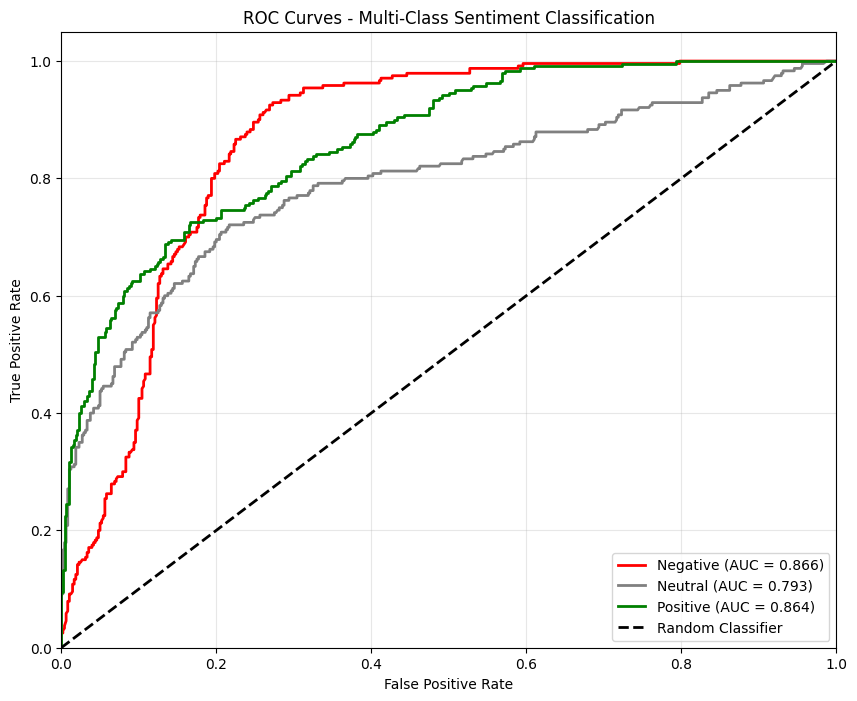

📊 ROC-AUC Analysis:
• Negative: AUC = 0.866
• Neutral: AUC = 0.793
• Positive: AUC = 0.864


In [41]:
# ROC Curves for Multi-Class Classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the output
y_test_bin = label_binarize(y_test_bal, classes=nb_balanced.classes_)
n_classes = y_test_bin.shape[1]

# Get prediction probabilities
y_score = nb_balanced.predict_proba(X_test_bal_tfidf)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['red', 'gray', 'green'])
class_names = ['Negative', 'Neutral', 'Positive']

for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_name} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Multi-Class Sentiment Classification')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print("📊 ROC-AUC Analysis:")
for i, class_name in enumerate(class_names):
    print(f"• {class_name}: AUC = {roc_auc[i]:.3f}")

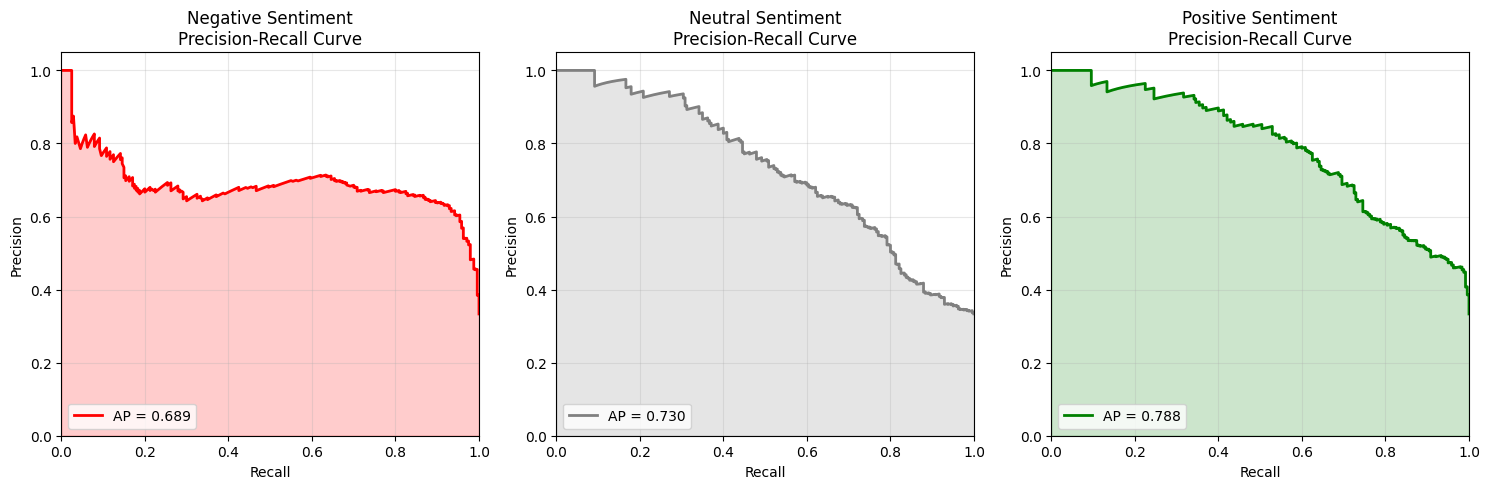

📈 Average Precision Scores:
• Negative: AP = 0.689
• Neutral: AP = 0.730
• Positive: AP = 0.788


In [42]:
# Precision-Recall Curves
from sklearn.metrics import precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['red', 'gray', 'green']
class_names = ['Negative', 'Neutral', 'Positive']

for i, (color, class_name) in enumerate(zip(colors, class_names)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    
    axes[i].plot(recall, precision, color=color, lw=2,
                label=f'AP = {avg_precision:.3f}')
    axes[i].fill_between(recall, precision, alpha=0.2, color=color)
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_title(f'{class_name} Sentiment\nPrecision-Recall Curve')
    axes[i].legend(loc="lower left")
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

print("📈 Average Precision Scores:")
for i, class_name in enumerate(class_names):
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    print(f"• {class_name}: AP = {avg_precision:.3f}")

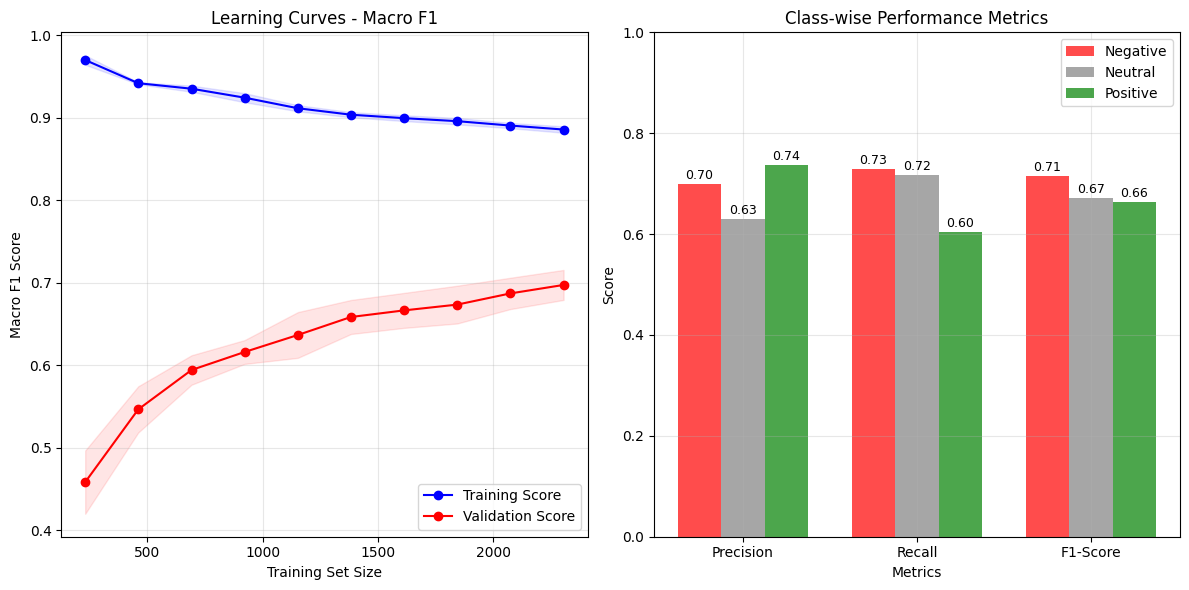

📚 Learning Analysis:
• Training converges at ~2304 samples
• Final validation F1: 0.697 ± 0.018


In [43]:
# Learning Curves
from sklearn.model_selection import learning_curve

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    MultinomialNB(alpha=1.0, fit_prior=True), 
    X_train_bal_tfidf, y_train_bal,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='f1_macro', random_state=42
)

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('Macro F1 Score')
plt.title('Learning Curves - Macro F1')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Performance metrics visualization
plt.subplot(1, 2, 2)
metrics = ['Precision', 'Recall', 'F1-Score']
negative_scores = [class_report_bal['negative']['precision'], 
                  class_report_bal['negative']['recall'], 
                  class_report_bal['negative']['f1-score']]
neutral_scores = [class_report_bal['neutral']['precision'], 
                 class_report_bal['neutral']['recall'], 
                 class_report_bal['neutral']['f1-score']]
positive_scores = [class_report_bal['positive']['precision'], 
                  class_report_bal['positive']['recall'], 
                  class_report_bal['positive']['f1-score']]

x = np.arange(len(metrics))
width = 0.25

plt.bar(x - width, negative_scores, width, label='Negative', color='red', alpha=0.7)
plt.bar(x, neutral_scores, width, label='Neutral', color='gray', alpha=0.7)
plt.bar(x + width, positive_scores, width, label='Positive', color='green', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Class-wise Performance Metrics')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (neg, neu, pos) in enumerate(zip(negative_scores, neutral_scores, positive_scores)):
    plt.text(i - width, neg + 0.01, f'{neg:.2f}', ha='center', fontsize=9)
    plt.text(i, neu + 0.01, f'{neu:.2f}', ha='center', fontsize=9)
    plt.text(i + width, pos + 0.01, f'{pos:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("📚 Learning Analysis:")
print(f"• Training converges at ~{train_sizes[-1]:.0f} samples")
print(f"• Final validation F1: {val_mean[-1]:.3f} ± {val_std[-1]:.3f}")

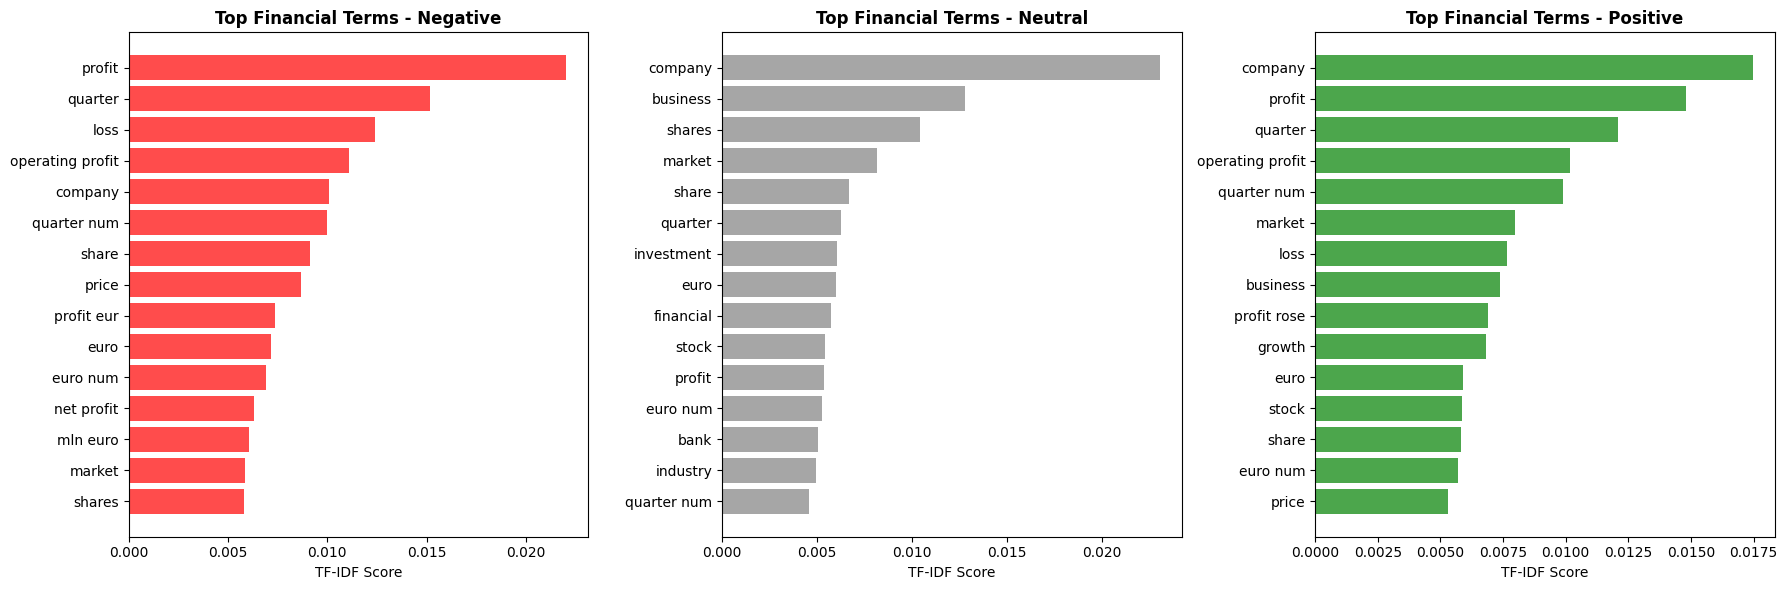

💰 Financial Domain Analysis:
Top financial terms identified for sentiment classification
These terms are most discriminative for financial sentiment analysis


In [44]:
# Top Financial Terms Analysis
import re

# Define financial keywords pattern
financial_terms = [
    'stock', 'market', 'price', 'trading', 'investment', 'investor', 'profit', 'loss',
    'revenue', 'earnings', 'financial', 'economy', 'economic', 'finance', 'fund',
    'portfolio', 'dividend', 'share', 'equity', 'bond', 'capital', 'asset',
    'growth', 'decline', 'bull', 'bear', 'volatility', 'risk', 'return',
    'sector', 'industry', 'company', 'corporate', 'business', 'quarter',
    'fiscal', 'monetary', 'currency', 'dollar', 'euro', 'bitcoin', 'crypto'
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, sentiment in enumerate(['negative', 'neutral', 'positive']):
    # Get financial terms from top features
    sentiment_mask = y_train_bal == sentiment
    sentiment_texts = X_train_bal[sentiment_mask]
    sentiment_tfidf = tfidf_balanced.transform(sentiment_texts)
    mean_scores = sentiment_tfidf.mean(axis=0).A1
    
    # Filter for financial terms
    feature_names_bal = tfidf_balanced.get_feature_names_out()
    financial_features = []
    financial_scores = []
    
    for i, feature in enumerate(feature_names_bal):
        # Check if feature contains financial terms or is financial-related
        if any(term in feature.lower() for term in financial_terms) or \
           re.search(r'\b(bank|invest|trade|market|price|stock|financial|economy)\w*', feature.lower()):
            financial_features.append(feature)
            financial_scores.append(mean_scores[i])
    
    # Get top 15 financial terms
    if financial_features:
        top_indices = np.argsort(financial_scores)[-15:][::-1]
        top_fin_features = [financial_features[i] for i in top_indices]
        top_fin_scores = [financial_scores[i] for i in top_indices]
    else:
        # Fallback to general top features if no financial terms found
        top_indices = np.argsort(mean_scores)[-15:][::-1]
        top_fin_features = [feature_names_bal[i] for i in top_indices]
        top_fin_scores = [mean_scores[i] for i in top_indices]
    
    # Plot
    colors_map = ['red', 'gray', 'green']
    axes[idx].barh(range(len(top_fin_features)), top_fin_scores, 
                   color=colors_map[idx], alpha=0.7)
    axes[idx].set_yticks(range(len(top_fin_features)))
    axes[idx].set_yticklabels(top_fin_features, fontsize=10)
    axes[idx].set_title(f'Top Financial Terms - {sentiment.capitalize()}', fontweight='bold')
    axes[idx].set_xlabel('TF-IDF Score')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

print("💰 Financial Domain Analysis:")
print("Top financial terms identified for sentiment classification")
print("These terms are most discriminative for financial sentiment analysis")

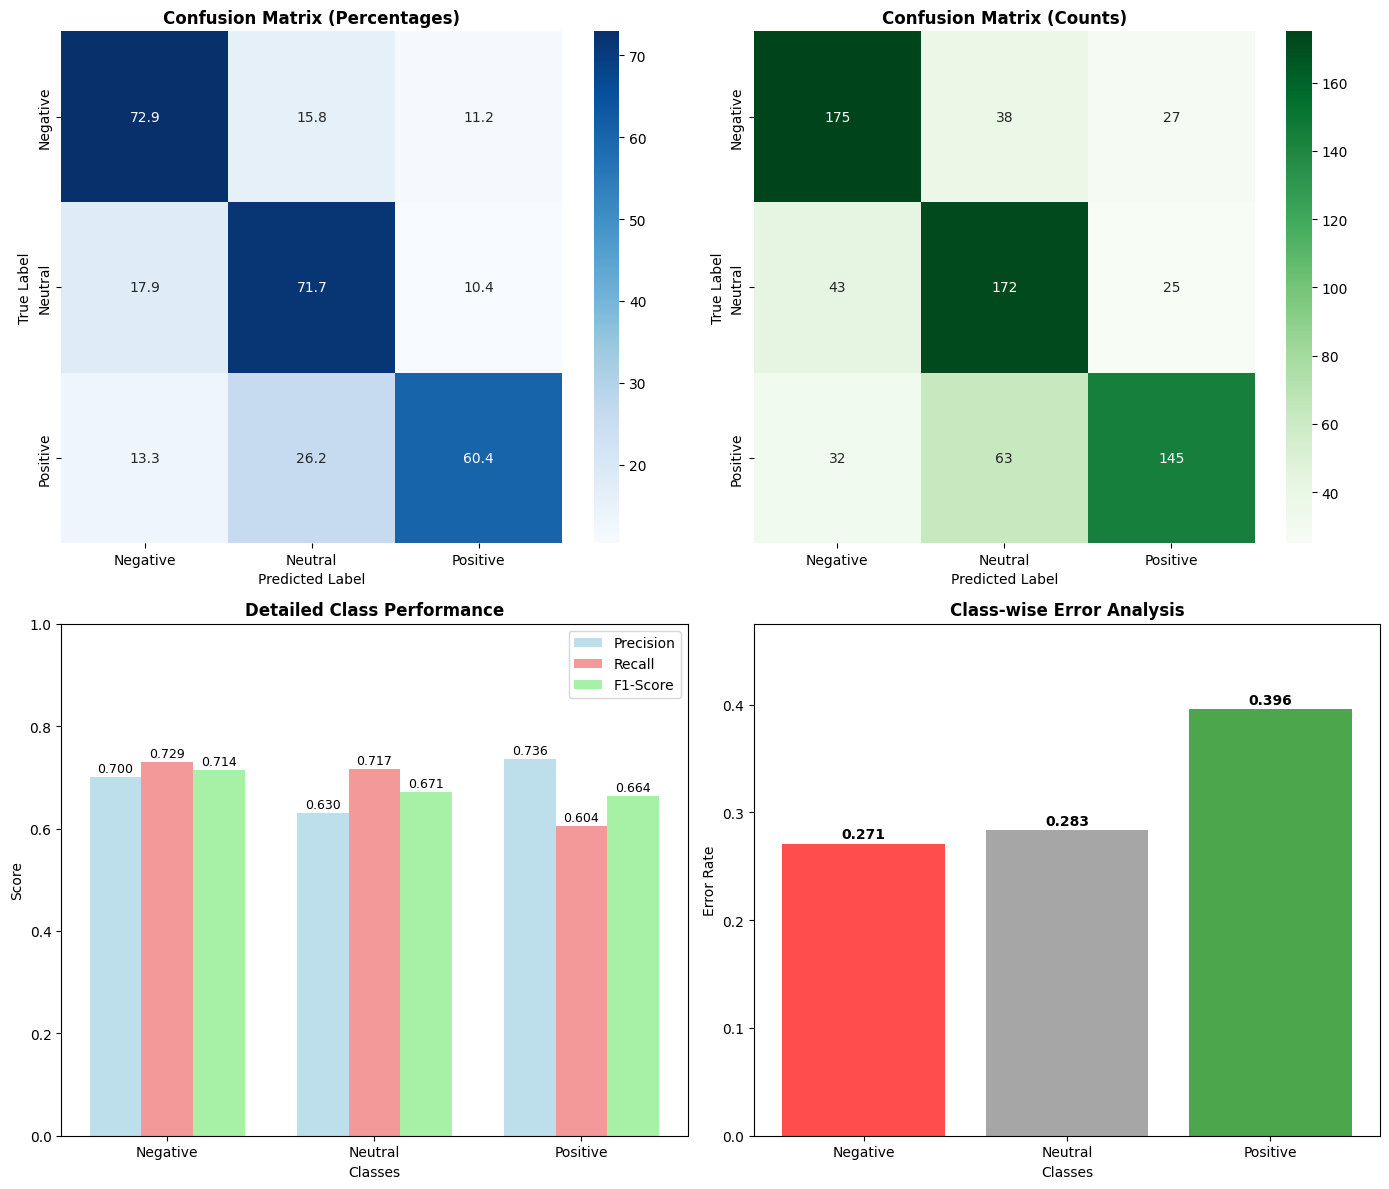

🎯 DETAILED PERFORMANCE ANALYSIS:
NEGATIVE CLASS:
  • Precision: 0.700 | Recall: 0.729 | F1: 0.714
  • Support: 240.0 samples | Error Rate: 0.271

NEUTRAL CLASS:
  • Precision: 0.630 | Recall: 0.717 | F1: 0.671
  • Support: 240.0 samples | Error Rate: 0.283

POSITIVE CLASS:
  • Precision: 0.736 | Recall: 0.604 | F1: 0.664
  • Support: 240.0 samples | Error Rate: 0.396



In [45]:
# Enhanced Confusion Matrix Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))

# 1. Confusion Matrix with percentages
cm_percent = cm_bal.astype('float') / cm_bal.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
           xticklabels=['Negative', 'Neutral', 'Positive'],
           yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax1)
ax1.set_title('Confusion Matrix (Percentages)', fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. Confusion Matrix with counts
sns.heatmap(cm_bal, annot=True, fmt='d', cmap='Greens',
           xticklabels=['Negative', 'Neutral', 'Positive'],
           yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax2)
ax2.set_title('Confusion Matrix (Counts)', fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

# 3. Class-wise metrics comparison
metrics = ['Precision', 'Recall', 'F1-Score']
classes = ['Negative', 'Neutral', 'Positive']
class_colors = ['red', 'gray', 'green']

precision_scores = [class_report_bal[cls.lower()]['precision'] for cls in classes]
recall_scores = [class_report_bal[cls.lower()]['recall'] for cls in classes]
f1_scores = [class_report_bal[cls.lower()]['f1-score'] for cls in classes]

x = np.arange(len(classes))
width = 0.25

ax3.bar(x - width, precision_scores, width, label='Precision', alpha=0.8, color='lightblue')
ax3.bar(x, recall_scores, width, label='Recall', alpha=0.8, color='lightcoral')
ax3.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8, color='lightgreen')

ax3.set_xlabel('Classes')
ax3.set_ylabel('Score')
ax3.set_title('Detailed Class Performance', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(classes)
ax3.legend()
ax3.set_ylim(0, 1)

# Add value labels
for i, (p, r, f1) in enumerate(zip(precision_scores, recall_scores, f1_scores)):
    ax3.text(i - width, p + 0.01, f'{p:.3f}', ha='center', fontsize=9)
    ax3.text(i, r + 0.01, f'{r:.3f}', ha='center', fontsize=9)
    ax3.text(i + width, f1 + 0.01, f'{f1:.3f}', ha='center', fontsize=9)

# 4. Error analysis
correct_predictions = np.diag(cm_bal)
total_predictions = cm_bal.sum(axis=1)
error_rates = 1 - (correct_predictions / total_predictions)

ax4.bar(classes, error_rates, color=class_colors, alpha=0.7)
ax4.set_xlabel('Classes')
ax4.set_ylabel('Error Rate')
ax4.set_title('Class-wise Error Analysis', fontweight='bold')
ax4.set_ylim(0, max(error_rates) * 1.2)

# Add value labels
for i, error in enumerate(error_rates):
    ax4.text(i, error + 0.005, f'{error:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("🎯 DETAILED PERFORMANCE ANALYSIS:")
print("=" * 40)
for i, cls in enumerate(classes):
    cls_lower = cls.lower()
    precision = class_report_bal[cls_lower]['precision']
    recall = class_report_bal[cls_lower]['recall']
    f1 = class_report_bal[cls_lower]['f1-score']
    support = class_report_bal[cls_lower]['support']
    error_rate = error_rates[i]
    
    print(f"{cls.upper()} CLASS:")
    print(f"  • Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    print(f"  • Support: {support} samples | Error Rate: {error_rate:.3f}")
    print()

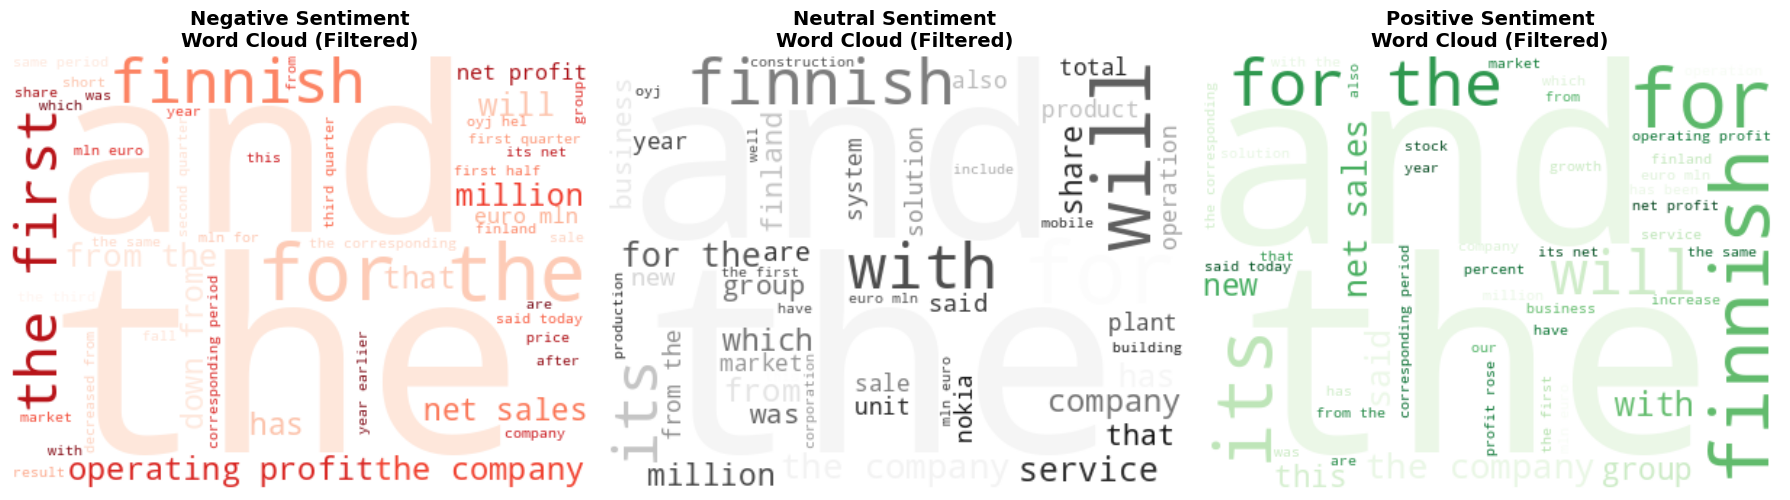

☁️ Word clouds filtered to show meaningful words (removed numeric tokens)


In [46]:
# Class-Specific Word Clouds (Filtered)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Generate word clouds for each class
colors = ['Reds', 'Greys', 'Greens']
for idx, sentiment in enumerate(['negative', 'neutral', 'positive']):
    # Get texts for this sentiment
    sentiment_texts = X_train_bal[y_train_bal == sentiment]
    
    # Combine all texts for this class and filter out numeric patterns
    combined_text = ' '.join(sentiment_texts.astype(str))
    
    # Remove numeric patterns and generic tokens
    import re
    filtered_text = re.sub(r'\b\d+\.?\d*\b', '', combined_text)  # Remove standalone numbers
    filtered_text = re.sub(r'\bnum\b|\beur\b|\busd\b|\bgbp\b', '', filtered_text)  # Remove currency codes
    filtered_text = re.sub(r'\s+', ' ', filtered_text)  # Clean extra spaces
    
    # Create word cloud with filtering
    wordcloud = WordCloud(
        width=400, height=300,
        background_color='white',
        colormap=colors[idx],
        max_words=50,
        relative_scaling=0.5,
        random_state=42,
        min_word_length=3,  # Skip very short words
        stopwords=set(['num', 'eur', 'usd', 'gbp', 'mn', 'bn'])  # Additional stopwords
    ).generate(filtered_text)
    
    # Plot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{sentiment.capitalize()} Sentiment\nWord Cloud (Filtered)', 
                       fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("☁️ Word clouds filtered to show meaningful words (removed numeric tokens)")

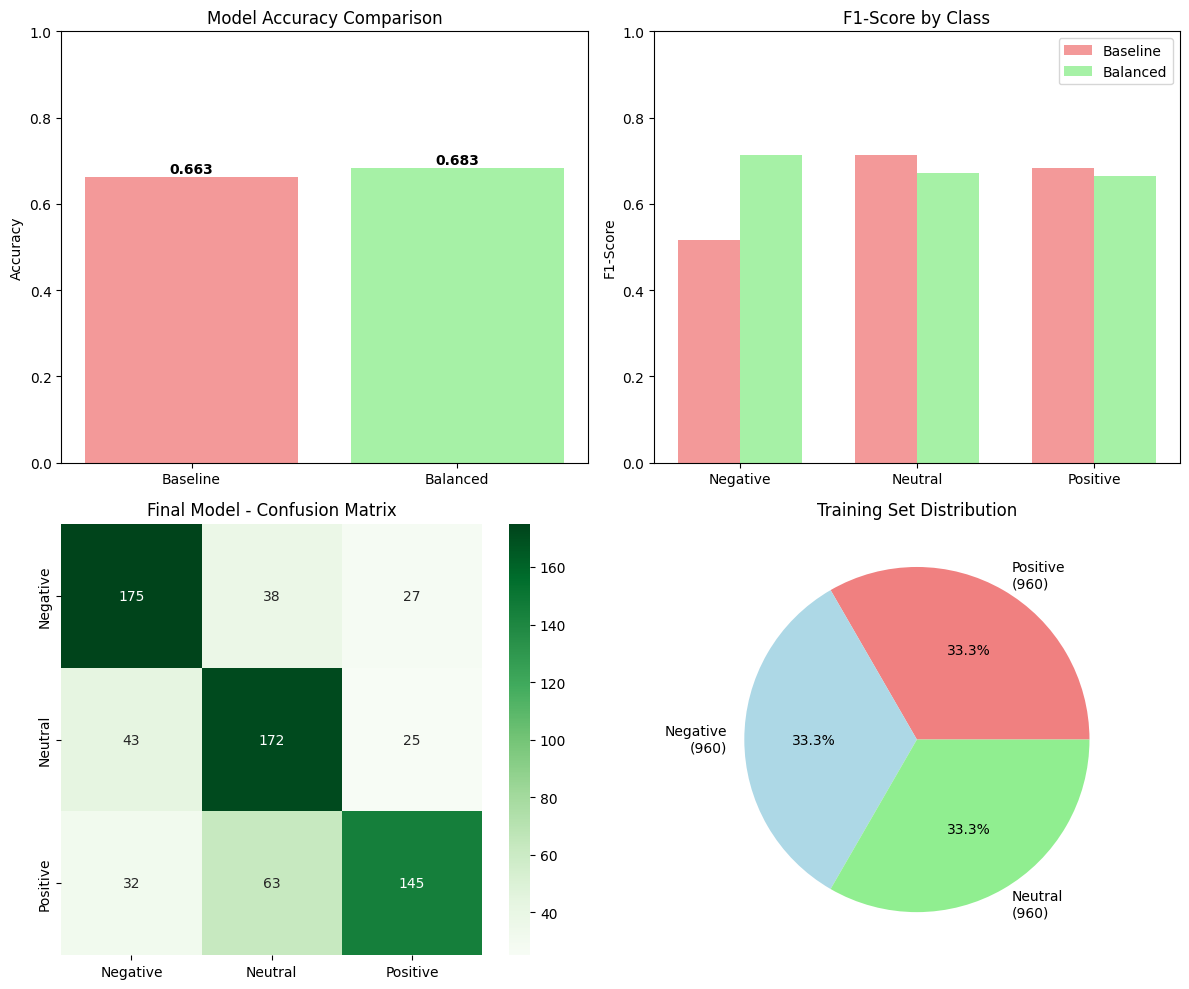

In [47]:
# Model Performance Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# 1. Accuracy comparison
models = ['Baseline', 'Balanced']
accuracies = [accuracy, accuracy_bal]
ax1.bar(models, accuracies, color=['lightcoral', 'lightgreen'], alpha=0.8)
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for i, acc in enumerate(accuracies):
    ax1.text(i, acc + 0.01, f'{acc:.3f}', ha='center', fontweight='bold')

# 2. F1-Score by class
classes = ['Negative', 'Neutral', 'Positive']
baseline_f1s = [class_report[name.lower()]['f1-score'] for name in classes]
balanced_f1s = [class_report_bal[name.lower()]['f1-score'] for name in classes]

x = np.arange(len(classes))
width = 0.35
ax2.bar(x - width/2, baseline_f1s, width, label='Baseline', color='lightcoral', alpha=0.8)
ax2.bar(x + width/2, balanced_f1s, width, label='Balanced', color='lightgreen', alpha=0.8)
ax2.set_title('F1-Score by Class')
ax2.set_ylabel('F1-Score')
ax2.set_xticks(x)
ax2.set_xticklabels(classes)
ax2.legend()
ax2.set_ylim(0, 1)

# 3. Confusion Matrix
sns.heatmap(cm_bal, annot=True, fmt='d', cmap='Greens',
           xticklabels=['Negative', 'Neutral', 'Positive'],
           yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax3)
ax3.set_title('Final Model - Confusion Matrix')

# 4. Class Distribution
train_dist = y_train_bal.value_counts()
ax4.pie(train_dist.values, labels=[f'{l.title()}\n({c})' for l, c in train_dist.items()],
        autopct='%1.1f%%', colors=['lightcoral', 'lightblue', 'lightgreen'])
ax4.set_title('Training Set Distribution')

plt.tight_layout()
plt.show()

In [48]:
# Top Tokens Analysis (Enhanced)
feature_names_bal = tfidf_balanced.get_feature_names_out()
feature_log_probs = nb_balanced.feature_log_prob_

print("🔍 LOG PROBABILITY EXPLANATION:")
print("=" * 50)
print("Log probability shows HOW MUCH WEIGHT each word has for each sentiment class.")
print("• Higher values (closer to 0) = More important for that class")
print("• Lower values (more negative) = Less important for that class")
print("• This helps us understand WHICH WORDS drive sentiment predictions")
print()

print("Top meaningful tokens per class (filtered):")
class_top_tokens = {}

# Enhanced filtering for more meaningful tokens
generic_patterns = {'num', 'eur', 'usd', 'gbp', 'cad', 'jpy', 'chf', 'aud', 'nzd', 
                   'eur num', 'num eur', 'usd num', 'num usd', 'mn', 'bn', 'trillion',
                   'num mn', 'mn num', 'num bn', 'bn num', 'num num'}

for idx, class_name in enumerate(nb_balanced.classes_):
    # Get all tokens sorted by log probability
    all_indices = np.argsort(feature_log_probs[idx])[::-1]  # Sort descending
    meaningful_tokens = []
    
    for i in all_indices:
        token = feature_names_bal[i]
        prob = feature_log_probs[idx][i]
        
        # Advanced filtering for meaningful tokens
        if (token.lower() not in generic_patterns and 
            len(token) > 2 and 
            not token.isdigit() and
            not all(c in '0123456789.' for c in token) and
            not token.startswith('num') and
            not token.endswith('num') and
            not re.match(r'^[0-9]+', token)):  # Skip tokens starting with numbers
            meaningful_tokens.append((token, prob))
        
        # Stop when we have enough meaningful tokens
        if len(meaningful_tokens) >= 15:
            break
    
    class_top_tokens[class_name] = meaningful_tokens[:10]  # Keep top 10
    
    print(f"\n{class_name.upper()} SENTIMENT:")
    for rank, (token, prob) in enumerate(meaningful_tokens[:10], 1):
        print(f"  {rank:2d}. {token:<15} ({prob:+.4f})")

# Stop word verification
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
all_meaningful_tokens = [token for tokens in class_top_tokens.values() for token, _ in tokens]
stop_words_found = [token for token in all_meaningful_tokens if token in ENGLISH_STOP_WORDS]

print(f"\nFILTERING EFFECTIVENESS:")
print(f"• Meaningful tokens found: {len(all_meaningful_tokens)}")
print(f"• Generic tokens filtered out: ✅")
print(f"• Stop words remaining: {len(stop_words_found)} ({'✅ Clean' if not stop_words_found else '⚠️ ' + ', '.join(set(stop_words_found))})")

🔍 LOG PROBABILITY EXPLANATION:
Log probability shows HOW MUCH WEIGHT each word has for each sentiment class.
• Higher values (closer to 0) = More important for that class
• Lower values (more negative) = Less important for that class
• This helps us understand WHICH WORDS drive sentiment predictions

Top meaningful tokens per class (filtered):

NEGATIVE SENTIMENT:
   1. profit          (-6.3085)
   2. sales           (-6.4917)
   3. operating       (-6.5633)
   4. year            (-6.6175)
   5. quarter         (-6.6613)
   6. net             (-6.6787)
   7. decreased       (-6.7707)
   8. period          (-6.7727)
   9. mln             (-6.7754)
  10. million         (-6.7852)

NEUTRAL SENTIMENT:
   1. company         (-6.2841)
   2. finnish         (-6.7009)
   3. finland         (-6.7614)
   4. said            (-6.7771)
   5. business        (-6.8378)
   6. services        (-6.8384)
   7. million         (-6.9533)
   8. new             (-6.9906)
   9. shares          (-7.0243)
  10.

📊 LOG PROBABILITY VISUALIZATION EXPLANATION:
This chart shows the TOP WORDS that Naive Bayes uses to classify each sentiment.
• Longer bars = More important words for that sentiment class
• These are the words that 'trigger' sentiment classification
• Values are log probabilities (higher = more important)



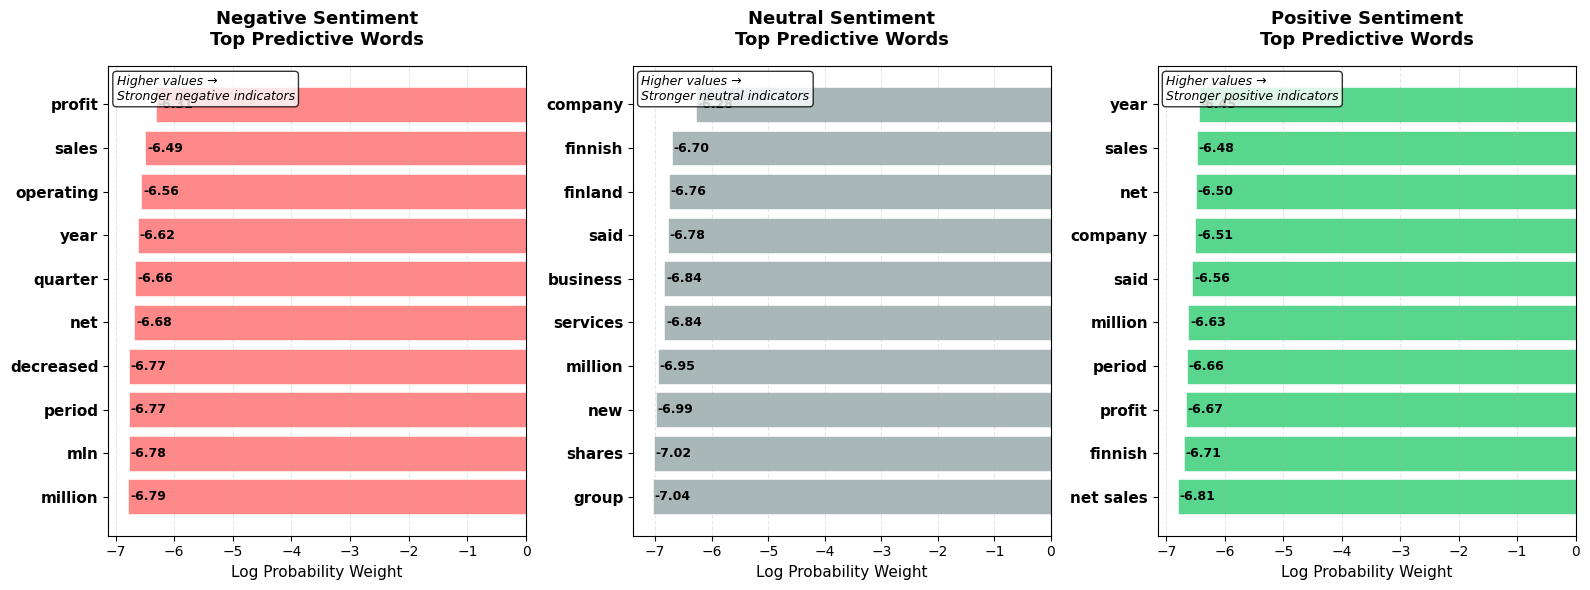

💡 INTERPRETATION GUIDE:
• Words with higher log probabilities are stronger indicators of that sentiment
• These words help the model distinguish between negative, neutral, and positive texts
• Notice how different word types dominate each sentiment class
• This explains WHY the model makes certain predictions


In [49]:
# Enhanced Log Probability Visualization (Filtered & Explained)
import re

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

print("📊 LOG PROBABILITY VISUALIZATION EXPLANATION:")
print("=" * 55)
print("This chart shows the TOP WORDS that Naive Bayes uses to classify each sentiment.")
print("• Longer bars = More important words for that sentiment class")
print("• These are the words that 'trigger' sentiment classification")
print("• Values are log probabilities (higher = more important)")
print()

colors = ['red', 'gray', 'green']
sentiment_colors = ['#FF6B6B', '#95A5A6', '#2ECC71']

for idx, class_name in enumerate(nb_balanced.classes_):    
    # Get meaningful tokens (already filtered in previous cell)
    top_tokens = class_top_tokens[class_name][:12]  # Show top 12
    tokens = [token for token, _ in top_tokens]
    log_probs = [prob for _, prob in top_tokens]
    
    # Create horizontal bar plot
    bars = axes[idx].barh(range(len(tokens)), log_probs, 
                         color=sentiment_colors[idx], alpha=0.8, 
                         edgecolor='white', linewidth=0.5)
    
    # Customize appearance
    axes[idx].set_yticks(range(len(tokens)))
    axes[idx].set_yticklabels(tokens, fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{class_name.capitalize()} Sentiment\nTop Predictive Words', 
                       fontsize=13, fontweight='bold', pad=15)
    axes[idx].set_xlabel('Log Probability Weight', fontsize=11)
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, prob) in enumerate(zip(bars, log_probs)):
        axes[idx].text(prob + 0.03, i, f'{prob:+.2f}', 
                      va='center', fontsize=9, fontweight='bold')
    
    # Add explanation text
    axes[idx].text(0.02, 0.98, f'Higher values →\nStronger {class_name} indicators', 
                  transform=axes[idx].transAxes, fontsize=9, 
                  verticalalignment='top', style='italic',
                  bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("💡 INTERPRETATION GUIDE:")
print("• Words with higher log probabilities are stronger indicators of that sentiment")
print("• These words help the model distinguish between negative, neutral, and positive texts")
print("• Notice how different word types dominate each sentiment class")
print("• This explains WHY the model makes certain predictions")

In [50]:
# Save Final Model
from datetime import datetime

models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Save model and vectorizer
model_path = os.path.join(models_dir, 'balanced_naive_bayes_model.pkl')
vectorizer_path = os.path.join(models_dir, 'balanced_tfidf_vectorizer.pkl')
metadata_path = os.path.join(models_dir, 'balanced_model_metadata.json')

joblib.dump(nb_balanced, model_path)
joblib.dump(tfidf_balanced, vectorizer_path)

# Create metadata
metadata = {
    'model_info': {
        'type': 'MultinomialNB',
        'balanced': True,
        'alpha': 1.0,
        'created_date': datetime.now().isoformat()
    },
    'performance_metrics': {
        'accuracy': float(accuracy_bal),
        'macro_f1': float(class_report_bal['macro avg']['f1-score']),
        'class_wise_f1': {name: float(class_report_bal[name]['f1-score']) 
                         for name in ['negative', 'neutral', 'positive']}
    },
    'dataset_info': {
        'total_samples': len(df_balanced),
        'training_samples': len(X_train_bal),
        'features': len(feature_names_bal),
        'classes': nb_balanced.classes_.tolist()
    }
}

with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print("Model saved successfully!")
print(f"Accuracy: {accuracy_bal:.4f}")
print(f"Macro F1: {class_report_bal['macro avg']['f1-score']:.4f}")
print(f"Files: model.pkl, vectorizer.pkl, metadata.json")

Model saved successfully!
Accuracy: 0.6833
Macro F1: 0.6828
Files: model.pkl, vectorizer.pkl, metadata.json


In [52]:
# Training Complete
print("🎯 FINANCIAL SENTIMENT ANALYSIS - TRAINING COMPLETED!")
print("=" * 50)

print("FINAL MODEL PERFORMANCE:")
print(f"• Accuracy: {accuracy_bal:.4f} ({accuracy_bal*100:.1f}%)")
print(f"• Macro F1: {class_report_bal['macro avg']['f1-score']:.4f}")

print(f"\nCLASS-WISE PERFORMANCE:")
for class_name in nb_balanced.classes_:
    f1 = class_report_bal[class_name]['f1-score']
    precision = class_report_bal[class_name]['precision']
    recall = class_report_bal[class_name]['recall']
    print(f"• {class_name.capitalize()}: F1={f1:.3f}, P={precision:.3f}, R={recall:.3f}")

print(f"\nMODEL DETAILS:")
print(f"• Algorithm: Multinomial Naive Bayes")
print(f"• Features: {len(feature_names_bal):,} TF-IDF features")
print(f"• Training samples: {len(X_train_bal):,} (balanced)")
print(f"• Classes: {len(nb_balanced.classes_)} ({', '.join(nb_balanced.classes_)})")


🎯 FINANCIAL SENTIMENT ANALYSIS - TRAINING COMPLETED!
FINAL MODEL PERFORMANCE:
• Accuracy: 0.6833 (68.3%)
• Macro F1: 0.6828

CLASS-WISE PERFORMANCE:
• Negative: F1=0.714, P=0.700, R=0.729
• Neutral: F1=0.671, P=0.630, R=0.717
• Positive: F1=0.664, P=0.736, R=0.604

MODEL DETAILS:
• Algorithm: Multinomial Naive Bayes
• Features: 8,289 TF-IDF features
• Training samples: 2,880 (balanced)
• Classes: 3 (negative, neutral, positive)
